In [60]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Стандартизатор признаков
from sklearn.preprocessing import StandardScaler

# Моделки
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM


plt.style.use("seaborn-v0_8")
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)

In [61]:
CS = 'CS_2.csv'
Train = 'brg_data.csv'

In [62]:
cs_df = df = pd.read_csv(CS, index_col='Date&time', parse_dates=['Date&time'])
cs_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1020 entries, 2022-01-16 06:00:00 to 2022-01-16 22:59:00
Data columns (total 37 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   N2      1020 non-null   int64  
 1   N1      1020 non-null   int64  
 2   P2      1020 non-null   float64
 3   T1      1020 non-null   float64
 4   N3      1020 non-null   int64  
 5   Qtg     1020 non-null   int64  
 6   V1      1020 non-null   float64
 7   VoГГ    1020 non-null   float64
 8   3.77F2  1020 non-null   float64
 9   Fтк4    1020 non-null   float64
 10  3F2     1020 non-null   float64
 11  Tк.з.   1020 non-null   float64
 12  Lm1     1020 non-null   float64
 13  T638    1020 non-null   float64
 14  V2      1020 non-null   float64
 15  ТРК     1020 non-null   float64
 16  dPfgo   1020 non-null   float64
 17  dPf2    1020 non-null   float64
 18  dPf1    1020 non-null   float64
 19  T607    1020 non-null   float64
 20  T606    1020 non-null   float64
 21  T

C:\Users\eugen\AppData\Local\Temp\ipykernel_54692\154322329.py:1: UserWarning: Parsing dates in %d.%m.%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  cs_df = df = pd.read_csv(CS, index_col='Date&time', parse_dates=['Date&time'])


In [63]:
dt = cs_df.index.to_series().diff().dt.total_seconds()
for i in ['Fтк4', 'Fc4','Fc2', 'Fc3']:
    cs_df[f'd{i}'] = cs_df[i].diff() / dt

In [64]:
train_df = pd.read_csv(Train)

# Обучение модели

Введение учебного и тестового датасета

In [65]:
scaler = StandardScaler()
train = train_df.copy()
test = cs_df.copy()

train.shape, test.shape

((143164, 17), (1020, 41))

Укажем сенсорные признаки

In [131]:
sensor_columns = {
    'Fтк4': ['Гармоника вращ. тел кач. подшипника передней опоры КВД', 'мм/с'],
    'Fc4': ['Гармоника вращ. сепаратора подшипника передней опоры КВД', 'мм/с'],
    'Fc2': ['Гарм. вращ. сепар. подш. задней опоры КНД', 'мм/с'],
    'Fc3': ['Гарм. вращ. сепар. подш. передней опоры КНД', 'мм/с'],
}
'''    'dFтк4': ['Гармоника вращ. тел кач. подшипника передней опоры КВД', 'мм/с'],
    'dFc4': ['Гармоника вращ. сепаратора подшипника передней опоры КВД', 'мм/с'],
    'dFc2': ['Гарм. вращ. сепар. подш. задней опоры КНД', 'мм/с'],
    'dFc3': ['Гарм. вращ. сепар. подш. передней опоры КНД', 'мм/с']
'''


"    'dFтк4': ['Гармоника вращ. тел кач. подшипника передней опоры КВД', 'мм/с'],\n    'dFc4': ['Гармоника вращ. сепаратора подшипника передней опоры КВД', 'мм/с'],\n    'dFc2': ['Гарм. вращ. сепар. подш. задней опоры КНД', 'мм/с'],\n    'dFc3': ['Гарм. вращ. сепар. подш. передней опоры КНД', 'мм/с']\n"

In [132]:
X_train = train[list(sensor_columns.keys())]
X_test = test[list(sensor_columns.keys())]

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Обучим модель


In [152]:
model = IsolationForest(
    n_estimators=400,
    contamination=0.05, # ожидаемая доля аномалий
    random_state=42
)

model.fit(X_train)

,"n_estimators n_estimators: int, default=100The number of base estimators in the ensemble.",400
,"max_samples max_samples: ""auto"", int or float, default=""auto""The number of samples to draw from X to train each base estimator.- If int, then draw `max_samples` samples.- If float, then draw `max_samples * X.shape[0]` samples.- If ""auto"", then `max_samples=min(256, n_samples)`.If max_samples is larger than the number of samples provided,all samples will be used for all trees (no sampling).",'auto'
,"contamination contamination: 'auto' or float, default='auto'The amount of contamination of the data set, i.e. the proportionof outliers in the data set. Used when fitting to define the thresholdon the scores of the samples.- If 'auto', the threshold is determined as in the original paper.- If float, the contamination should be in the range (0, 0.5]... versionchanged:: 0.22 The default value of ``contamination`` changed from 0.1 to ``'auto'``.",0.05
,"max_features max_features: int or float, default=1.0The number of features to draw from X to train each base estimator.- If int, then draw `max_features` features.- If float, then draw `max(1, int(max_features * n_features_in_))` features.Note: using a float number less than 1.0 or integer less than number offeatures will enable feature subsampling and leads to a longer runtime.",1.0
,"bootstrap bootstrap: bool, default=FalseIf True, individual trees are fit on random subsets of the trainingdata sampled with replacement. If False, sampling without replacementis performed.",False
,"n_jobs n_jobs: int, default=NoneThe number of jobs to run in parallel for :meth:`fit`. ``None`` means 1unless in a :obj:`joblib.parallel_backend` context. ``-1`` means usingall processors. See :term:`Glossary ` for more details.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the pseudo-randomness of the selection of the featureand split values for each branching step and each tree in the forest.Pass an int for reproducible results across multiple function calls.See :term:`Glossary `.",42
,"verbose verbose: int, default=0Controls the verbosity of the tree building process.",0
,"warm_start warm_start: bool, default=FalseWhen set to ``True``, reuse the solution of the previous call to fitand add more estimators to the ensemble, otherwise, just fit a wholenew forest. See :term:`the Glossary `... versionadded:: 0.21",False


In [153]:
train['anomaly_score'] = model.decision_function(X_train)
train['anomaly_flag'] = model.predict(X_train)

test['anomaly_score'] = model.decision_function(X_test)
test['anomaly_flag'] = model.predict(X_test)

train['anomaly_flag'] = (train['anomaly_flag'] == -1).astype(int)
test['anomaly_flag'] = (test['anomaly_flag'] == -1).astype(int)

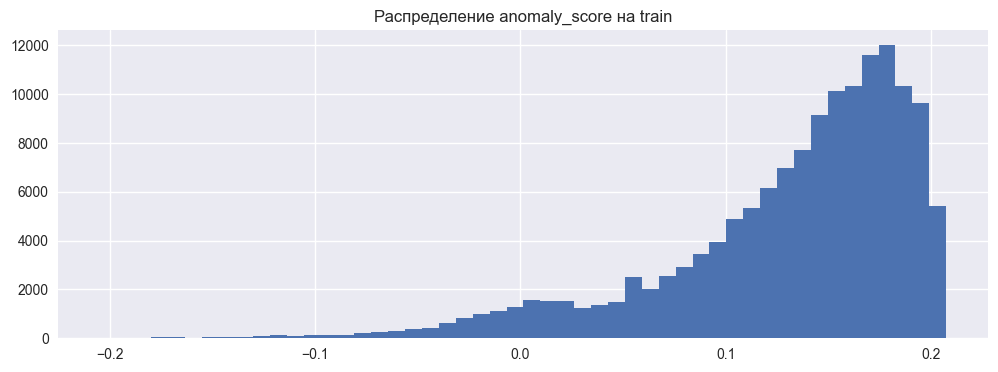

In [154]:
plt.figure(figsize=(12, 4))
plt.hist(train['anomaly_score'], bins=50)
plt.title('Распределение anomaly_score на train')
plt.show()

In [161]:
window = 10

test['anomaly_rate'] = (test['anomaly_flag'].rolling(window=window).mean())
test['anomaly_score_smooth'] = (test['anomaly_score'].rolling(window=window).mean())
test['smoothed_score_ewma'] = test['anomaly_score'].ewm(alpha=0.2).mean()
threshold = train['anomaly_score'].quantile(0.1)

threshold


np.float64(0.04109553417206441)

In [173]:
test['early_warning'] = (test['anomaly_score_smooth'] < threshold).astype(int)

# 2. Проверка на постоянство (например, 3 минуты подряд)
# Используем rolling.sum(), чтобы посчитать количество "единиц" в окне

N = 3
test['confirmed_anomaly'] = (test['early_warning'].rolling(window=N).sum() == N).astype(int)

# 3. Находим индекс ПЕРВОЙ подтвержденной аномалии
first_true_anomaly = test['confirmed_anomaly'].idxmax()

if test.loc[first_true_anomaly, 'confirmed_anomaly'] == 1:
    print(f"ПОДТВЕРЖДЕННАЯ АНОМАЛИЯ: {first_true_anomaly}")
else:
    print("Стабильных аномалий не обнаружено.")


ПОДТВЕРЖДЕННАЯ АНОМАЛИЯ: 2022-01-16 19:17:00


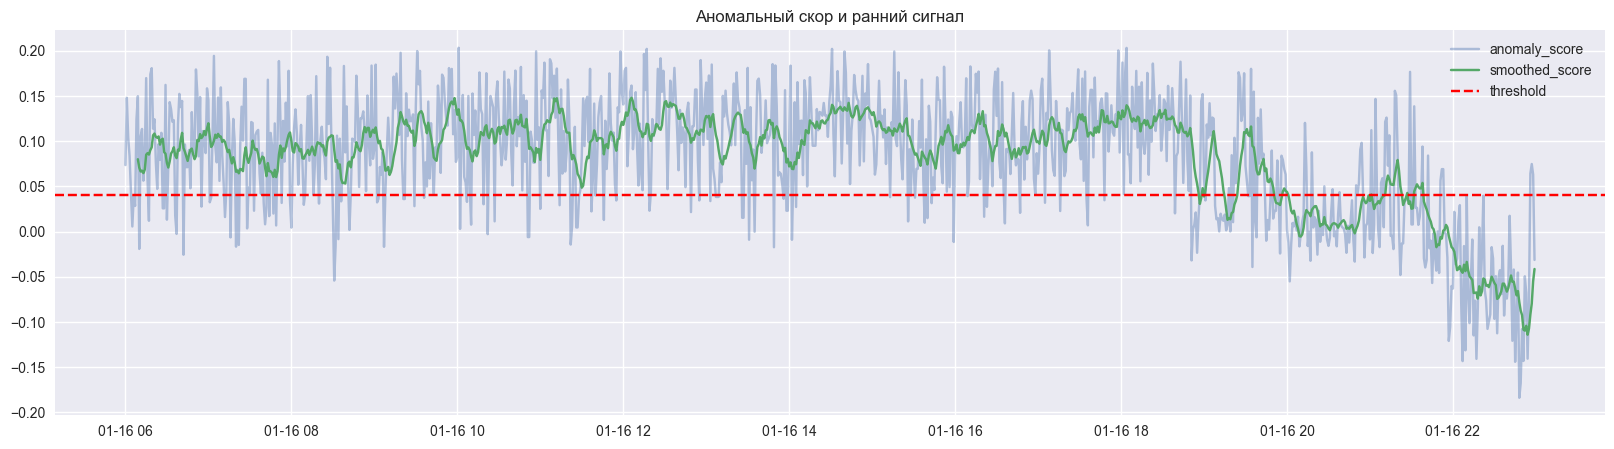

In [163]:
plt.figure(figsize=(20, 5))

plt.plot(test.index, test['anomaly_score'], alpha=0.4, label='anomaly_score')
plt.plot(test.index, test['anomaly_score_smooth'], label='smoothed_score')
plt.axhline(threshold, color='red', linestyle='--', label='threshold')

plt.legend()
plt.title('Аномальный скор и ранний сигнал')
plt.show()
